## Hardware Embedded Fingerprinting Based on Electric Noise

In [ ]:
"""
This notebook is based on the official Keras example:
https://github.com/keras-team/keras-io/blob/master/examples/timeseries/timeseries_classification_from_scratch.py

We modified it to train on custom time-series data extracted from PWM signals of two Arduino Uno boards,
as part of our published work: "Hardware Embedded Fingerprinting Based on Electric Noise" (ACIT 2025).
"""

import keras
import numpy as np
import matplotlib.pyplot as plt

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0] #select all rows and only first column
    x = data[:, 1:] # select all row and all columns from second column onwards
    return x, y.astype(int)

root_url = "/content/drive/MyDrive/Embedded Project/"

x_train, y_train = readucr(root_url + "EP_TrainDataset_L.tsv")
x_test, y_test = readucr(root_url + "EP_TestDataset_L.tsv")

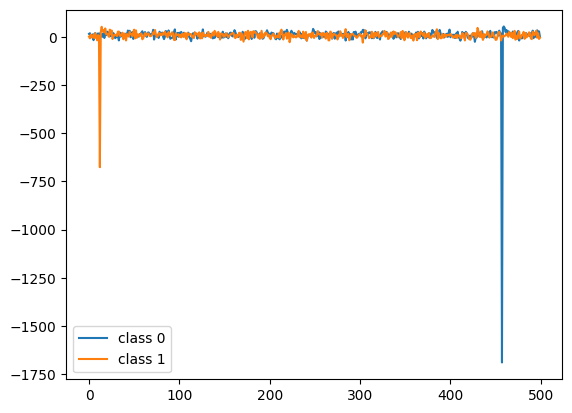

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[90], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Number of Instances

In [ ]:
# Training Dataset
num_instances_train = x_train.shape[0]

# Test Dataset
num_instances_test = x_test.shape[0]

print("Number of instances in the training dataset:", num_instances_train)
print("Number of instances in the test dataset:", num_instances_test)


Number of instances in the training dataset: 1440
Number of instances in the test dataset: 360


## Model Architecture & Training

In [ ]:

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    conv4 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv3)
    conv4 = keras.layers.BatchNormalization()(conv4)
    conv4 = keras.layers.ReLU()(conv4)

    conv5 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv4)
    conv5 = keras.layers.BatchNormalization()(conv5)
    conv5 = keras.layers.ReLU()(conv5)

    gap = keras.layers.GlobalAveragePooling1D()(conv5)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "low_model_copy.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

model.save("/content/drive/MyDrive/Embedded Project/low_model_copy.keras")


Epoch 1/500
36/36 [==============================] - 12s 240ms/step - loss: 0.5448 - sparse_categorical_accuracy: 0.7587 - val_loss: 2.1190 - val_sparse_categorical_accuracy: 0.5208 - lr: 0.0010
Epoch 2/500
36/36 [==============================] - 9s 249ms/step - loss: 0.3982 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.9520 - val_sparse_categorical_accuracy: 0.5208 - lr: 0.0010
Epoch 3/500
36/36 [==============================] - 7s 200ms/step - loss: 0.3375 - sparse_categorical_accuracy: 0.8767 - val_loss: 0.4735 - val_sparse_categorical_accuracy: 0.8299 - lr: 0.0010
Epoch 4/500
36/36 [==============================] - 9s 245ms/step - loss: 0.3003 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.9001 - val_sparse_categorical_accuracy: 0.5208 - lr: 0.0010
Epoch 5/500
36/36 [==============================] - 7s 186ms/step - loss: 0.2390 - sparse_categorical_accuracy: 0.9358 - val_loss: 0.7451 - val_sparse_categorical_accuracy: 0.5382 - lr: 0.0010
Epoch 6/500
36/36 [==========

## Model Evalutaion

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Embedded Project/low_model_copy.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

12/12 [==============================] - 1s 59ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9417
Test accuracy 0.9416666626930237
Test loss 0.15194721519947052


## Confusion Matrix

12/12 [==============================] - 1s 46ms/step


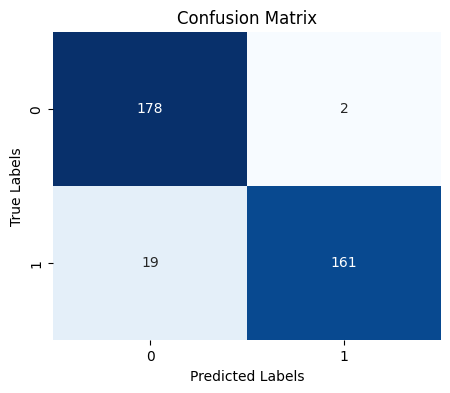

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use the trained model to predict probabilities for the test dataset
y_pred_probs = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()